In [6]:
import os
import json
import regex as re
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
from collections import Counter
import shutil

In [7]:
def normalize (line):
    return line.replace("　", " ").replace('\n', ' ').replace("  ", " ")

def extract (jsonfp):
    jsonobj = json.load (jsonfp)
    if "paragraphs" not in jsonobj:
        raise RuntimeError ("Invalid JSON data")
    for paragraph in jsonobj["paragraphs"]:
        for cue in paragraph["cues"]:
            yield (int(cue["time"]), normalize(cue["text"]))
            
def create_txt (f_json, f_txt):
    with open (f_txt, 'w') as txtfp:
        with open (f_json, 'rt') as jsonfp:
                prev = None
                for time, text in extract (jsonfp):
                    if prev != None:
                        txtfp.write("%d\t%d\t%s" % (prev[0], time, prev[1]) + '\n')
                    prev = (time, text)
                txtfp.write("%d\t%d\t%s" % (prev[0], prev[0], prev[1]) + '\n')

In [8]:
# identify which speechs have been translated by all three ranks of interpreters
speeches = []
old_p_dir = 'EJ/TED/'
p_dir = 'TED/'

for folder in os.listdir(old_p_dir):
    if os.path.isdir(old_p_dir + folder):
        S = A = B = False
        for filename in os.listdir(old_p_dir + folder):
            if filename.endswith("rank_S.tsv"):
                S = True
            elif filename.endswith("rank_A.tsv"):
                A = True
            elif filename.endswith("rank_B.tsv"):
                B = True
        if S and A and B:
            shutil.copytree(old_p_dir + folder, p_dir + folder)
            speeches.append(p_dir + folder)
print('Number of talks interpreted by all three ranks:', len(speeches))

Number of talks interpreted by all three ranks: 14


In [9]:
# extract english and japanese translation text

for folder in os.listdir(p_dir):
    if os.path.isdir(p_dir + folder):
        for filename in os.listdir(p_dir + folder):
            if filename.endswith(".json"):
                p_json = p_dir + folder + '/' + filename
                p_txt = p_dir + folder + '/' + filename[0:2] + '_extracted.tsv'
                create_txt(p_json, p_txt)

In [10]:
# count number of English substitutions for each rank interpreter

ignore = ['(F ', '(P)', '<H>', '(NOISE)', 'ー', '{', '}']
han_pattern = re.compile(r'([\p{IsHan}]+)', re.UNICODE)
hira_pattern = re.compile(r'([\p{IsHira}]+)', re.UNICODE)
kana_pattern = re.compile(r'([\p{IsKatakana}\ー]+)', re.UNICODE)
notate_pattern = re.compile(r'\(F |\(P\)|<H>|\(NOISE\)', re.UNICODE)
latin_pattern = re.compile(r'([\p{IsLatin}]+)', re.UNICODE)

def get_char(str):
    string = re.sub(notate_pattern, '', str)
    c_han = re.findall(han_pattern, string)
    c_hira = re.findall(hira_pattern, string)
    c_kana = re.findall(kana_pattern, string)
    c_latin = re.findall(latin_pattern, string)
    return c_han, c_hira, c_kana, c_latin

def count_char(str):
    han = re.findall(han_pattern, str)
    hira = re.findall(hira_pattern, str)
    kana = re.findall(kana_pattern, str)
    latin = re.findall(latin_pattern, str)
    # n_han = sum([len(x) for x in han])
    # n_hira = sum([len(x) for x in hira])
    # n_kana = sum([len(x) for x in kana])
    # n_latin = sum([len(x) for x in latin if x not in ignore])
    n_han = len(han)
    n_hira = len(hira)
    n_kana = len(kana)
    n_latin = len([x for x in latin if x not in ignore])
    return n_han, n_hira, n_kana, n_latin

count_df = pd.DataFrame(columns=['file', 'rank', 'n_han', 'n_hira', 'n_kana', 'n_latin', 'n_total', 'han', 'hira', 'kana', 'latin'])

for folder in speeches:
    for filename in os.listdir(folder + '/'):
        if 'rank_' not in filename:
            continue
        p_tsv = folder + '/' + filename
        rank = filename.split('.')[1]
        df = pd.read_csv(p_tsv, sep='\t', header=None, on_bad_lines='skip')
        n_han, n_hira, n_kana, n_latin = count_char(''.join(df[3]))
        c_han, c_hira, c_kana, c_latin = get_char(' '.join(df[3]))
        count_df.loc[len(count_df)] = [folder, rank, 
                                        n_han, n_hira, n_kana, n_latin, len(''.join(df[3])),
                                        c_han, c_hira, c_kana, c_latin]
count_df.head(3)

,file,rank,n_han,n_hira,n_kana,n_latin,n_total,han,hira,kana,latin
0,TED/MiruKim_2008P,rank_S,557,1013,199,194,5081,"[私, 韓国, 育, 千九百九十九年, 移, 時, 外科医, 解剖, 興味, 動物, 解剖,...","[はえ, し, で, ちました, に, りました, その, え, になりたかったんです, え...","[ー, ニューヨーク, ニューヨーク, ー, ニューヨーク, エムディー, ー, ー, ー,...","[ＭＤ, ＭＴＡ, R, ＩＫＥＡ, Ｘ]"
1,TED/MiruKim_2008P,rank_B,679,984,102,55,4805,"[韓国, 育, 千九百九十九年, 移, 来, 医学生, 外科医, 興味, 頃動物, 大好, ...","[す, の, で, ってきまして, き, に, に, って, ました, まだ, いがくせい,...","[ソウル, ニューヨーク, ニューヨーク, ネズミ, ネズミ, ペスト, カメラ, ネズミ,...","[L, L, L, L]"
2,TED/MiruKim_2008P,rank_A,496,1020,331,349,5485,"[私, 韓国, 育, 千九百九十九年, 方, 移, 私, 解剖, 興味, 有, 外科医, 思...","[え, は, の, で, え, ちました, え, にえ, の, にえ, ったんですけれども,...","[ー, ソウル, ー, ー, ー, ニューヨーク, ー, ー, ー, ー, ー, ー, ー,...",[ＭＴＡ]


In [11]:
# most frequently used latin words
latin_txt_list = list([x for y in count_df['latin'] for x in y if len(x)>1])
latin_txt_freq = collections.Counter(latin_txt_list)
print(', '.join([str(k) + ' (' + str(v) + ')' for k,v in latin_txt_freq.most_common(10)]))


ＡＩ (42), ＰＴＳＤ (21), ＮＡＳＡ (12), ＣＯ (7), ｉＰｈｏｎｅ (5), ＭＩＴ (5), ＣＥＯ (4), ＮＲＡ (3), ＩＴ (3), ＧＤＰ (3)


# analyze by speech

In [12]:
def calc_avg(ser):
    return round(np.sum(ser)/14.0, 2)

by_speech_df = pd.DataFrame(columns=['rank', 'years', 'avg_n_han', 'avg_n_hira', 'avg_n_kana', 'avg_n_latin', 'avg_n_total'])
ranks = ['rank_S', 'rank_A', 'rank_B']
years = {'rank_S': 15, 'rank_A': 4, 'rank_B': 1}
for rank in ranks:
    df = count_df[count_df['rank'] == rank]
    by_speech_df.loc[len(by_speech_df)] = [rank, years[rank], 
                                calc_avg(df['n_han']), calc_avg(df['n_hira']), calc_avg(df['n_kana']), calc_avg(df['n_latin']),
                                calc_avg(df['n_han']+df['n_hira']+df['n_kana']+df['n_latin'])]
by_speech_df

,rank,years,avg_n_han,avg_n_hira,avg_n_kana,avg_n_latin,avg_n_total
0,rank_S,15,635.93,1096.36,181.86,150.64,2064.79
1,rank_A,4,551.57,1040.57,206.71,274.71,2073.57
2,rank_B,1,694.29,1016.93,86.14,51.21,1848.57


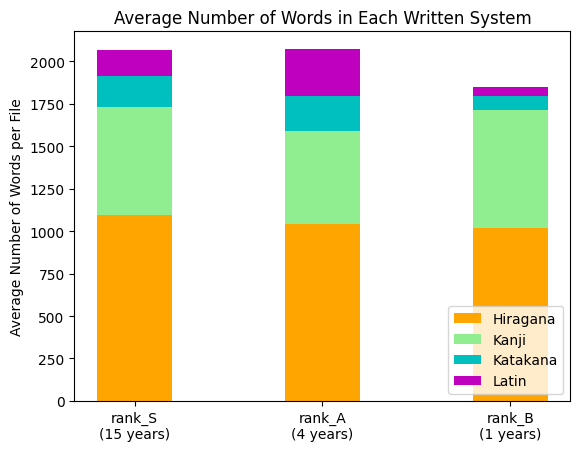

In [13]:

width = 0.4

fig, ax = plt.subplots()
bottom = np.zeros(3)

labels = [rank + '\n(' + str(int(by_speech_df[by_speech_df['rank'] == rank]['years'])) + ' years)' for rank in ranks]
colors=['orange', 'lightgreen', 'c', 'm']
props = {
    'Hiragana': [float(by_speech_df[by_speech_df['rank'] == rank]['avg_n_hira']) for rank in ranks],
    'Kanji': [float(by_speech_df[by_speech_df['rank'] == rank]['avg_n_han']) for rank in ranks],
    'Katakana': [float(by_speech_df[by_speech_df['rank'] == rank]['avg_n_kana']) for rank in ranks],
    'Latin': [float(by_speech_df[by_speech_df['rank'] == rank]['avg_n_latin']) for rank in ranks]
}

for script, prop in props.items():
    p = ax.bar(labels, prop, width, label=script, bottom=bottom, color=colors[list(props.keys()).index(script)])
    bottom += prop

ax.set_title("Average Number of Words in Each Written System")
ax.set_ylabel("Average Number of Words per File")
ax.legend(loc="lower right")

plt.show()


avg_n_hira [0.531, 0.5018, 0.5501]
avg_n_han [0.308, 0.266, 0.3756]
avg_n_kana [0.0881, 0.0997, 0.0466]
avg_n_latin [0.073, 0.1325, 0.0277]


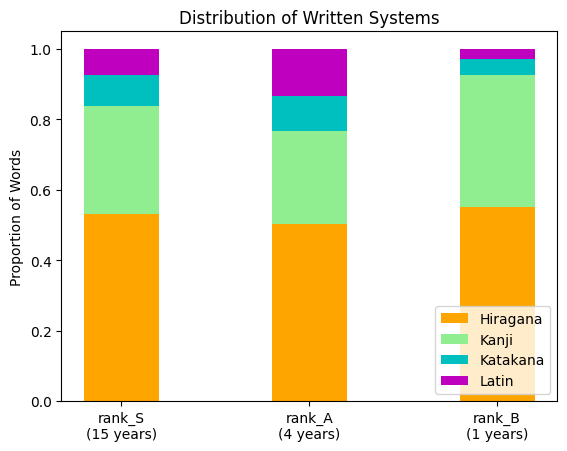

In [14]:
def calc_prop(script):
    n_script = [round(
        float(by_speech_df[by_speech_df['rank'] == rank][script])
        /float(by_speech_df[by_speech_df['rank'] == rank]['avg_n_total'])
        , 4) for rank in ranks]
    print(script, n_script)
    return n_script

width = 0.4

fig, ax = plt.subplots()
bottom = np.zeros(3)

labels = [rank + '\n(' + str(int(by_speech_df[by_speech_df['rank'] == rank]['years'])) + ' years)' for rank in ranks]
colors=['orange', 'lightgreen', 'c', 'm']
props = {
    'Hiragana': calc_prop('avg_n_hira'),
    'Kanji': calc_prop('avg_n_han'),
    'Katakana': calc_prop('avg_n_kana'),
    'Latin': calc_prop('avg_n_latin')
}

for script, prop in props.items():
    p = ax.bar(labels, prop, width, label=script, bottom=bottom, color=colors[list(props.keys()).index(script)])
    bottom += prop

ax.set_title("Distribution of Written Systems")
ax.set_ylabel("Proportion of Words")
ax.legend(loc="lower right")

plt.show()


# analyze by rank

In [15]:
# sanity check
count_df['rank'].value_counts()

rank_S    14
rank_B    14
rank_A    14
Name: rank, dtype: int64

In [16]:
# analyze for each rank

years = {'rank_S': 15, 'rank_A': 4, 'rank_B': 1}
by_rank_df = pd.DataFrame(columns=['rank', 'n_total_units', 'years',
                                   'n_unique_latin', 'latin_ratio',
                                   'n_unique_han', 'han_ratio', 
                                   'n_unique_hira', 'hira_ratio', 
                                   'n_unique_kana', 'kana_ratio'])
by_rank_txt_df = pd.DataFrame(columns=['rank', 'n_file', 'latin_txt', 'han_txt', 'hira_txt', 'kana_txt'])

for rank in ranks:
    df = count_df[count_df['rank'] == rank]
    n_file = count_df['rank'].value_counts()[rank]
    latin_txt = [y.upper() for x in [df.iloc[i]['latin'] for i in range(len(df))] for y in x if len(y)>1]  
    han_txt = [y.upper() for x in [df.iloc[i]['han'] for i in range(len(df))] for y in x]    
    hira_txt = [y.upper() for x in [df.iloc[i]['hira'] for i in range(len(df))] for y in x]    
    kana_txt = [y.upper() for x in [df.iloc[i]['kana'] for i in range(len(df))] for y in x]   
    n_total_units = len(latin_txt) + len(han_txt) + len(hira_txt) + len(kana_txt)
    by_rank_df.loc[len(by_rank_df)] = [rank, n_total_units, years[rank],
                                       len(np.unique(latin_txt)), round(len(latin_txt)/n_total_units, 4),
                                       len(np.unique(han_txt)), round(len(han_txt)/n_total_units, 4),
                                       len(np.unique(hira_txt)), round(len(hira_txt)/n_total_units, 4), 
                                       len(np.unique(kana_txt)), round(len(kana_txt)/n_total_units, 4)]
    by_rank_txt_df.loc[len(by_rank_txt_df)] = [rank, n_file, latin_txt, han_txt, hira_txt, kana_txt]
by_rank_df.head(3)

,rank,n_total_units,years,n_unique_latin,latin_ratio,n_unique_han,han_ratio,n_unique_hira,hira_ratio,n_unique_kana,kana_ratio
0,rank_S,26467,15,25,0.0023,1851,0.3363,3061,0.5651,851,0.0962
1,rank_A,24509,4,13,0.0015,1679,0.3148,2469,0.5657,562,0.1180
2,rank_B,25160,1,12,0.0013,1886,0.3870,3146,0.5638,503,0.0479


In [17]:
# look at ratio by rank
for rank in ranks:
    print('For rank =', rank)
    df = by_rank_df[by_rank_df['rank'] == rank]
    print('Proportion of latin words =', float(df['latin_ratio']))
    print('Proportion of kana words =', float(df['kana_ratio']))
    print('Proportion of han+hira words =', float(df['han_ratio']) + float(df['hira_ratio']))


For rank = rank_S
Proportion of latin words = 0.0023
Proportion of kana words = 0.0962
Proportion of han+hira words = 0.9014
For rank = rank_A
Proportion of latin words = 0.0015
Proportion of kana words = 0.118
Proportion of han+hira words = 0.8805000000000001
For rank = rank_B
Proportion of latin words = 0.0013
Proportion of kana words = 0.0479
Proportion of han+hira words = 0.9508


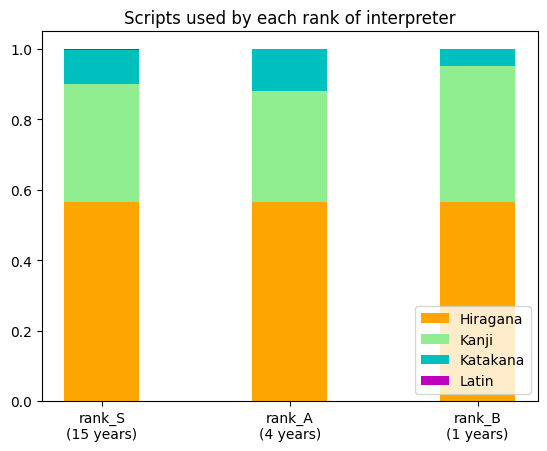

In [18]:
width = 0.4

fig, ax = plt.subplots()
bottom = np.zeros(3)

labels = [rank + '\n(' + str(int(by_rank_df[by_rank_df['rank'] == rank]['years'])) + ' years)' for rank in ranks]
colors=['orange', 'lightgreen', 'c', 'm']
props = {
    'Hiragana': [float(by_rank_df[by_rank_df['rank'] == rank]['hira_ratio']) for rank in ranks],
    'Kanji': [float(by_rank_df[by_rank_df['rank'] == rank]['han_ratio']) for rank in ranks],
    'Katakana': [float(by_rank_df[by_rank_df['rank'] == rank]['kana_ratio']) for rank in ranks],
    'Latin': [float(by_rank_df[by_rank_df['rank'] == rank]['latin_ratio']) for rank in ranks]
}

for script, prop in props.items():
    p = ax.bar(labels, prop, width, label=script, bottom=bottom, color=colors[list(props.keys()).index(script)])
    bottom += prop

ax.set_title("Scripts used by each rank of interpreter")
ax.legend(loc="lower right")

plt.show()

In [19]:
# most frequently used latin words by rank

for rank in ranks:
    df = by_rank_txt_df[by_rank_txt_df['rank'] == rank]
    latin_txt_list = list([x for y in df['latin_txt'] for x in y if len(x)>1])
    latin_txt_freq = collections.Counter(latin_txt_list)
    print('for rank =', rank, '\n', ', '.join([str(k) + ' (' + str(v) + ')' for k,v in latin_txt_freq.most_common(15)]))
    

for rank = rank_S 
 ＡＩ (19), ＰＴＳＤ (8), ＩＰＨＯＮＥ (5), ＮＡＳＡ (5), ＭＩＴ (2), ＩＴ (2), ＣＥＯ (2), ＣＯ (2), ＭＤ (1), ＭＴＡ (1), ＩＫＥＡ (1), ＡＴＭ (1), ＴＯＹＯＴＡ (1), ＮＲＡ (1), ＴＥＤ (1)
for rank = rank_A 
 ＡＩ (11), ＰＴＳＤ (7), ＣＯ (5), ＮＡＳＡ (4), ＯＣＤ (2), ＭＴＡ (1), ＡＴＭ (1), ＤＣ (1), ＧＤＰ (1), ＣＣＴ (1), ＤＮＡ (1), ＭＩＴ (1), ＴＶ (1)
for rank = rank_B 
 ＡＩ (12), ＰＴＳＤ (6), ＮＡＳＡ (3), ＮＲＡ (2), ＭＩＴ (2), ＣＥＯ (2), ＤＣ (1), ＡＦＬ (1), ＧＤＰ (1), ＳＦ (1), ＩＴ (1), ＴＶ (1)


In [20]:
list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == rank]['latin_txt'] for x in y])

['ＮＲＡ',
 'ＮＲＡ',
 'ＤＣ',
 'ＡＦＬ',
 'ＧＤＰ',
 'ＡＩ',
 'ＳＦ',
 'ＡＩ',
 'ＡＩ',
 'ＡＩ',
 'ＡＩ',
 'ＡＩ',
 'ＩＴ',
 'ＡＩ',
 'ＡＩ',
 'ＡＩ',
 'ＡＩ',
 'ＡＩ',
 'ＡＩ',
 'ＭＩＴ',
 'ＰＴＳＤ',
 'ＰＴＳＤ',
 'ＰＴＳＤ',
 'ＰＴＳＤ',
 'ＰＴＳＤ',
 'ＰＴＳＤ',
 'ＮＡＳＡ',
 'ＮＡＳＡ',
 'ＣＥＯ',
 'ＣＥＯ',
 'ＮＡＳＡ',
 'ＭＩＴ',
 'ＴＶ']

length S = 25 ; length A = 13 ; length B = 12
A intersect S = 10 out of 13 in A
B intersect A = 7 out of 12 in B
B intersect S = 8 out of 12 in B


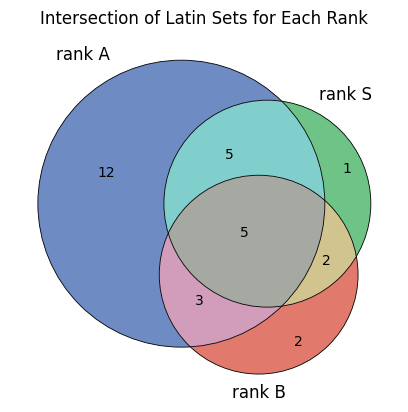

In [21]:
# compare sets

rank_s_latin_set = set(list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == 'rank_S']['latin_txt'] for x in y]))
rank_a_latin_set = set(list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == 'rank_A']['latin_txt'] for x in y]))
rank_b_latin_set = set(list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == 'rank_B']['latin_txt'] for x in y]))

print('length S =', len(rank_s_latin_set), '; length A =', len(rank_a_latin_set),'; length B =', len(rank_b_latin_set))

print('A intersect S =', len(rank_s_latin_set.intersection(rank_a_latin_set)), 'out of', len(rank_a_latin_set), 'in A')
print('B intersect A =', len(rank_a_latin_set.intersection(rank_b_latin_set)), 'out of', len(rank_b_latin_set), 'in B')
print('B intersect S =', len(rank_s_latin_set.intersection(rank_b_latin_set)), 'out of', len(rank_b_latin_set), 'in B')

venn3([rank_s_latin_set, rank_a_latin_set, rank_b_latin_set],
      set_labels = ('rank A', 'rank S', 'rank B'), 
      set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
      alpha=0.75)
venn3_circles([rank_s_latin_set, rank_a_latin_set, rank_b_latin_set], lw=0.6)
plt.title("Intersection of Latin Sets for Each Rank")
plt.show()


length S = 847 ; length A = 559 ; length B = 498
A intersect S = 294 out of 559 in A
B intersect A = 228 out of 498 in B
B intersect S = 256 out of 498 in B


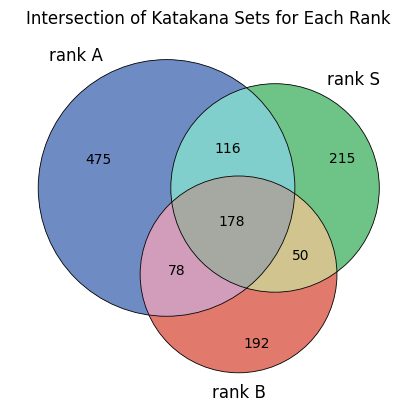

In [22]:
# compare sets

rank_s_kana_set = set(list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == 'rank_S']['kana_txt'] for x in y if len(x)>1]))
rank_a_kana_set = set(list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == 'rank_A']['kana_txt'] for x in y if len(x)>1]))
rank_b_kana_set = set(list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == 'rank_B']['kana_txt'] for x in y if len(x)>1]))

print('length S =', len(rank_s_kana_set), '; length A =', len(rank_a_kana_set),'; length B =', len(rank_b_kana_set))

print('A intersect S =', len(rank_s_kana_set.intersection(rank_a_kana_set)), 'out of', len(rank_a_kana_set), 'in A')
print('B intersect A =', len(rank_a_kana_set.intersection(rank_b_kana_set)), 'out of', len(rank_b_kana_set), 'in B')
print('B intersect S =', len(rank_s_kana_set.intersection(rank_b_kana_set)), 'out of', len(rank_b_kana_set), 'in B')

venn3([rank_s_kana_set, rank_a_kana_set, rank_b_kana_set],
      set_labels = ('rank A', 'rank S', 'rank B'), 
      set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
      alpha=0.75)
plt.title("Intersection of Katakana Sets for Each Rank")
venn3_circles([rank_s_kana_set, rank_a_kana_set, rank_b_kana_set], lw=0.6)

plt.show()


In [23]:
# compare each ranks frequency versus range of word substitution

# most frequently used latin words by rank
for rank in ranks:
    print(rank)
    word_list = list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == rank]['latin_txt'] for x in y])
    print(round(len(set(word_list)) /  len(word_list), 2)) 

rank_S
0.4
rank_A
0.35
rank_B
0.36


In [24]:
# compare each ranks frequency versus range of word substitution

# most frequently used latin words by rank
for rank in ranks:
    print(rank)
    word_list = list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == rank]['kana_txt'] for x in y])
    print(round(len(set(word_list)) /  len(word_list), 2)) 

rank_S
0.33
rank_A
0.19
rank_B
0.42


In [25]:
rank_s_latin_freq = Counter(list([x for y in by_rank_txt_df[by_rank_txt_df['rank'] == 'rank_S']['latin_txt'] for x in y]))
rank_s_latin_freq_avg = sum([v for k,v in rank_s_latin_freq.items()])
rank_s_latin_freq_avg

62